In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

sys.path.insert(0, "../")

%load_ext autoreload
%autoreload 2

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import src

In [3]:
from src.utils.vis_utils import render_mesh_onto_image_batch
from src.datasets.datasets_common import UNNORMALIZE

In [4]:
from src.models.hmr import get_hmr_pretrained
from src.functional import smpl
from src.functional.hmr import hmr_inference

device = "cuda:0"
hmrnet = get_hmr_pretrained("/cvlabdata2/home/davydov/videoHMR_SSL/eft_model_zoo/coco-all.pt").to(device)

smpl_model = smpl.get_smpl_model("extra", device=device)
smpl_model_faces = torch.tensor(smpl_model.faces.astype(int).copy()).unsqueeze(0).to(device)

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/hub.py:704: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


In [5]:
def get_of(model, frames_start, frames_end, device):
    """Compute optical flow using off-the-shelf model"""
    img1 = UNNORMALIZE(frames_start).to(device)
    img2 = UNNORMALIZE(frames_end).to(device)

    with torch.no_grad():
        # compute optical flow
        _, opt_flow = model(img1, img2, iters=20, test_mode=True)
    return opt_flow

from src.models import raft
### init optical flow model
optical_flow_model = raft.get_raft_pretrained().to(device)
optical_flow_model.eval();

from src.functional.renderer import get_default_cameras
### init cameras
cameras = get_default_cameras(device, mode="orthographic")

In [6]:
from src.datasets.threedpw import ThreeDPW
from src.datasets.h36m import Human36M
from src.datasets.pennaction import PennAction

In [7]:
from src.functional.renderer import (
    convert_vertices_to_mesh,
    fit_vertices_to_orthographic,
    get_vertex_visibility_mask,
    unproject_to_vertices,
)

def unproject_optical_flows_to_vertices(verts3d, of, faces, cameras):
    """
    Args:
        verts3d (torch.tensor) B x N x 3 - mesh vertices, start/end together.
            X,Y coordinates are in pixels.
        of (torch.tensor) B x 2 x H x W - optical flow
            (e.g., from the pretrained optical flow predictor)
        faces (torch.LongTensor) 1 x Ntri x 3 - faces indices for mesh
            Must be copied to batch size.
    Output:
        unproj_flow2d B x N x 2 - 2d flow unprojected on (assigned to) vertices
        vis_mask B x N - {0., 1.} mask of vertex visibility
    """
    ### map coordinates to NDC format
    img_size = of.size()[-2:]
    batch_size = verts3d.size(0)
    n_verts = verts3d.size(1)
    faces_batch = faces.repeat(batch_size, 1, 1).to(verts3d.device)
    verts3d = fit_vertices_to_orthographic(verts3d, img_size=img_size)
    meshes = convert_vertices_to_mesh(verts3d, faces_batch)

    ### compute visibility mask
    vis_mask = get_vertex_visibility_mask(meshes, cameras, img_size)
    vis_mask = vis_mask.view(verts3d.size(0), verts3d.size(1))

    ### unproject optical flow to vertices
    unproj_flow2d = unproject_to_vertices(of, verts3d)
    return unproj_flow2d, vis_mask

In [8]:
from easydict import EasyDict as edict
from src.losses.optical_flow import Flow2DLoss

d_full_normalizeOF = edict()

for normalize_OF in [True, False]:
    
    flow_2d_loss = Flow2DLoss(normalize_OF=normalize_OF, do_thresholding=True, reduction=None)
    d_full = edict()
    
    for dset_name in ["3dpw_test", "3dpw_train", "h36m_train", "h36m_test", "pennaction"]:
        print(dset_name, "...")
        if dset_name == "3dpw_test":
            dset = ThreeDPW(set="test", seqlen=2, debug=True)
        elif dset_name == "3dpw_train":
            dset = ThreeDPW(set="train", seqlen=2, debug=True)
        elif dset_name == "h36m_train":
            dset = Human36M(set="train", seqlen=2, debug=True)
        elif dset_name == "h36m_test":
            dset = Human36M(set="test", seqlen=2, debug=True)
        elif dset_name == "pennaction":
            dset = PennAction(seqlen=2, output_types=["video"])

        d_full[dset_name] = edict()
        ########

        flow_2d_f_arr = []

        torch.manual_seed(0)
        dataload = torch.utils.data.DataLoader(dset, batch_size=16, num_workers=24, shuffle=True)

        hmrnet.eval()
        num = 0

        for batch_idx, sample in tqdm(enumerate(dataload), total=len(dataload)):
            img = sample['video']
            img = img.to(device, non_blocking=True)
            batch_size = img.size(0)
            img_size = img.size(-1)

            ### compute optical flows
            of_f = get_of(optical_flow_model, img[:,0], img[:,1], device)

            ### inference
            with torch.no_grad():
                out = hmr_inference(
                        img.flatten(start_dim=0, end_dim=1), 
                        hmrnet, 
                        smpl_model)

            verts3d = out['verts3d']
            verts3d = verts3d.view(batch_size, 2, verts3d.size(-2), 3)

            unproj_flow2d_f, vis_mask_f = unproject_optical_flows_to_vertices(verts3d[:,0], of_f, smpl_model_faces, cameras)

            ###  mask should be the intersection
            vis_mask = vis_mask_f #* vis_mask_b  # B x N
            verts_flow2d_f  = verts3d[:, -1, :, :2] - verts3d[:, 0, :, :2]

            ### compute of loss
            flow_2d_f = flow_2d_loss(verts_flow2d_f, unproj_flow2d_f, vis_mask)
            flow_2d_f_arr.append(flow_2d_f.cpu())

            num += len(flow_2d_f)
            if num > 2000: break

        d_full[dset_name] = torch.cat(flow_2d_f_arr, dim=0)
    
    normOF_flag = "on" if normalize_OF else "off"
    d_full_normalizeOF[normOF_flag] = d_full
        

3dpw_test ...
3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 17273


  0%|                                                                                                                                                    | 0/1080 [00:00<?, ?it/s]/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643003845/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
 12%|███████████████▉                                                            

3dpw_train ...
3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/train/3dpw_train_db.pt
3dpw - number of dataset objects 11321


 18%|████████████████████████▌                                                                                                                  | 125/708 [00:42<03:17,  2.96it/s]


h36m_train ...
Human36M Dataset overlap ratio:  0.0
Loaded h36m dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/h36m/h36m_train_25fps_db.pt
h36m - number of dataset objects 146965


  1%|█▉                                                                                                                                        | 125/9186 [00:36<44:18,  3.41it/s]


h36m_test ...
Human36M Dataset overlap ratio:  0.0
Loaded h36m dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/h36m/h36m_test_25fps_db.pt
h36m - number of dataset objects 54386


  4%|█████                                                                                                                                     | 125/3400 [00:37<16:17,  3.35it/s]


pennaction ...
Loaded pennaction dataset from /cvlabsrc1/cvlab/dataset_PennAction/Penn_Action/../pennaction_train_scale12_db.pt
pennaction - number of dataset objects 81343


  2%|███▍                                                                                                                                      | 125/5084 [00:30<20:09,  4.10it/s]


3dpw_test ...
3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 17273


 12%|███████████████▉                                                                                                                          | 125/1080 [00:37<04:44,  3.35it/s]


3dpw_train ...
3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/train/3dpw_train_db.pt
3dpw - number of dataset objects 11321


 18%|████████████████████████▌                                                                                                                  | 125/708 [00:37<02:53,  3.35it/s]


h36m_train ...
Human36M Dataset overlap ratio:  0.0
Loaded h36m dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/h36m/h36m_train_25fps_db.pt
h36m - number of dataset objects 146965


  1%|█▉                                                                                                                                        | 125/9186 [00:40<49:05,  3.08it/s]


h36m_test ...
Human36M Dataset overlap ratio:  0.0
Loaded h36m dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/h36m/h36m_test_25fps_db.pt
h36m - number of dataset objects 54386


  4%|█████                                                                                                                                     | 125/3400 [00:37<16:24,  3.33it/s]


pennaction ...
Loaded pennaction dataset from /cvlabsrc1/cvlab/dataset_PennAction/Penn_Action/../pennaction_train_scale12_db.pt
pennaction - number of dataset objects 81343


  2%|███▍                                                                                                                                      | 125/5084 [00:29<19:31,  4.23it/s]


In [9]:
torch.save(d_full_normalizeOF, "../paper_sub/norm_loss_on_off/d.pth")

In [11]:
d = torch.load("../paper_sub/norm_loss_on_off/d.pth")
d_new = {}
for turn, v in d.items():
    d_new[turn] = {}
    for k, arr in v.items():
        arr_new = np.array(arr)
        d_new[turn][k] = arr_new

In [13]:
np.save("../paper_sub/norm_loss_on_off/d.npy", d_new)

In [16]:
np.load("../paper_sub/norm_loss_on_off/d.npy", allow_pickle=True).item()

{'on': {'3dpw_test': array([ 2.6976259,  2.2650907, 15.310168 , ...,  6.7168303,  6.2289085,
          1.3446887], dtype=float32),
  '3dpw_train': array([ 11.050927 ,  20.54721  , 246.86395  , ..., 122.405815 ,
         462.63104  ,   6.6162543], dtype=float32),
  'h36m_train': array([  6.8008127, 158.91096  ,  17.164688 , ...,  13.44418  ,
          13.787948 ,   2.6310625], dtype=float32),
  'h36m_test': array([ 1.4260871, 13.242581 , 37.505665 , ...,  3.8346586,  2.831445 ,
          3.2290978], dtype=float32),
  'pennaction': array([8.5584188e-01, 1.4239363e+01, 8.9242125e-01, ..., 2.3678235e+03,
         1.3872377e+01, 5.7051373e+01], dtype=float32)},
 'off': {'3dpw_test': array([1.6108978 , 1.903158  , 3.3956084 , ..., 0.08857165, 5.749774  ,
         0.6948882 ], dtype=float32),
  '3dpw_train': array([ 3.210238 ,  2.9486718,  9.1194105, ..., 13.697    , 16.791592 ,
          9.784575 ], dtype=float32),
  'h36m_train': array([12.523297  ,  0.27383184,  0.18977812, ...,  1.7934556

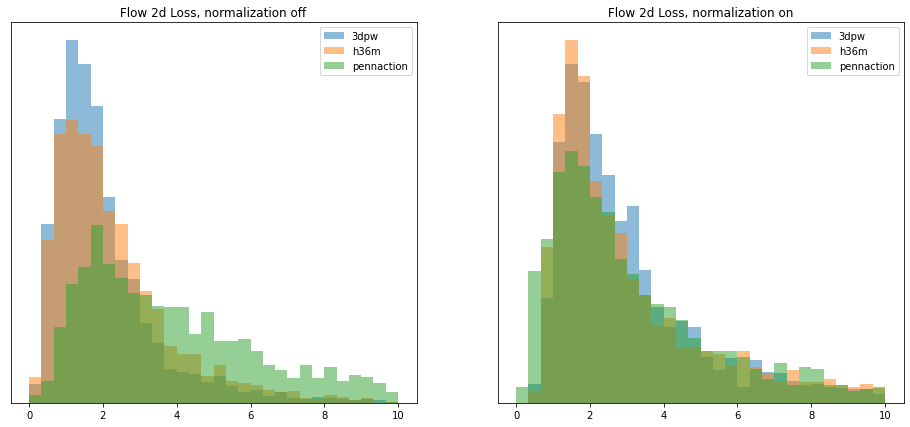

In [21]:
fig, ax = plt.subplots(1,2,figsize=(16,7))
range_ = (0,10)
for i, normOF_flag in enumerate(["off", "on"]):
    d_full = d_full_normalizeOF[normOF_flag]
    for dset_name in ["3dpw_test", "h36m_test", "pennaction"]:
        ax[i].hist(torch.sqrt(d_full[dset_name]), bins=30, range=range_, alpha=0.5, label=dset_name.split("_")[0]);
    ax[i].legend()
#     ax[i].set_xlim(range_)
    ax[i].yaxis.set_visible(False)
    ax[i].set_title(f"Flow 2d Loss, normalization {normOF_flag}")

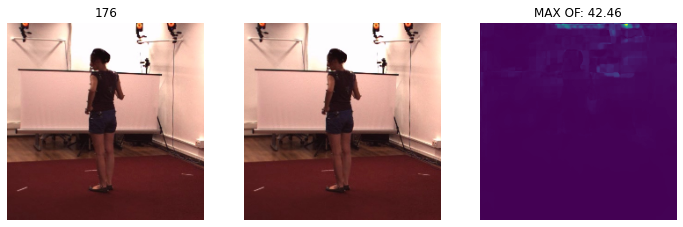

In [116]:
for idx in [
#     10*16 + 10, 
    11*16 + 0, 
]:  
    img = dset[idx]['video']
    with torch.no_grad():
        out = hmr_inference(img.to(device), hmrnet, smpl_model)
    rendered_imgs = render_mesh_onto_image_batch(
        UNNORMALIZE(img), 
        out["verts3d"].detach(), 
        faces=smpl_model_faces.repeat(img.size(0),1,1), 
        device=device)
    
    img = UNNORMALIZE(img)
    of_f = get_of(optical_flow_model, img.unsqueeze(0)[:,0], img.unsqueeze(0)[:,1], device)
    
#     imgs_plot = list(img.permute(0,2,3,1)) + list(rendered_imgs) + [of_f[0].norm(dim=0).cpu()]
    imgs_plot = list(img.permute(0,2,3,1)) + [of_f[0].norm(dim=0).cpu()]
    fig, ax = plt.subplots(1,len(imgs_plot),figsize=(4*len(imgs_plot),4))
    for img_, axis in zip(imgs_plot, ax):
        axis.imshow(img_)
        axis.set_axis_off()
    ax[0].set_title(idx)
    ax[-1].set_title(f"MAX OF: {of_f[0].norm(dim=0).max():.2f}")
        



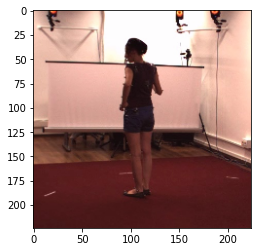

In [117]:
plt.imshow(UNNORMALIZE(dset[176]['video'])[0].permute(1,2,0))

In [128]:
img = dset[176]['video'].unsqueeze(0).to(device)
batch_size = img.size(0)
img_size = img.size(-1)

### compute optical flows
of_f = get_of(optical_flow_model, img[:,0], img[:,1], device)

### inference
with torch.no_grad():
    out = hmr_inference(
            img.flatten(start_dim=0, end_dim=1), 
            hmrnet, 
            smpl_model)

verts3d = out['verts3d']
verts3d = verts3d.view(batch_size, 2, verts3d.size(-2), 3)

unproj_flow2d_f, vis_mask_f = unproject_optical_flows_to_vertices(verts3d[:,0], of_f, smpl_model_faces, cameras)

###  mask should be the intersection
vis_mask = vis_mask_f #* vis_mask_b  # B x N

verts_flow2d_f  = verts3d[:, -1, :, :2] - verts3d[:, 0, :, :2]

### compute of loss
flow_2d_f, verts_flow_norm_f, of_norm_mean, of_norm_max = of_loss(
    verts_flow2d_f, 
    unproj_flow2d_f, 
    vis_mask, 
    normalize_OF=normalize_OF)

In [132]:
flow_2d_f, verts_flow_norm_f, of_norm_mean, of_norm_max

(tensor([0.4424], device='cuda:0'),
 tensor([0.4015], device='cuda:0'),
 tensor([0.1476], device='cuda:0'),
 tensor([0.2721], device='cuda:0'))

tensor(19.7738, device='cuda:0')


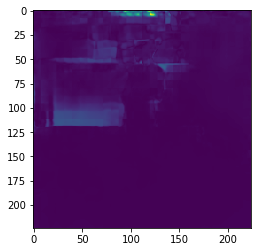

In [89]:
# img = UNNORMALIZE(dset[240]['video']).unsqueeze(0)
# of_f = get_of(optical_flow_model, img[:,0], img[:,1], device)
# print(of_f[0].norm(dim=0).max())
# plt.imshow(of_f[0].norm(dim=0).cpu())


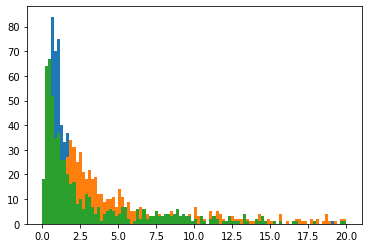

In [83]:
plt.hist(flow_2d_f_arr, bins=100, range=(0,20));
plt.hist(verts_flow_norm_arr, bins=100, range=(0,20));
plt.hist(of_norm_arr, bins=100, range=(0,20));

In [57]:
rendered_imgs = render_mesh_onto_image_batch(
    UNNORMALIZE(img[0]), 
    verts3d[0], 
    faces=smpl_model_faces.repeat(img[0].size(0),1,1), 
    device=device)

torch.Size([16, 6890, 2])

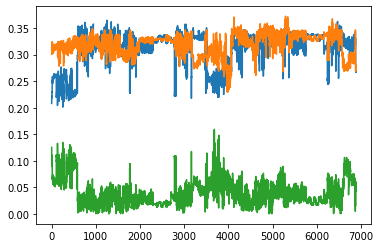

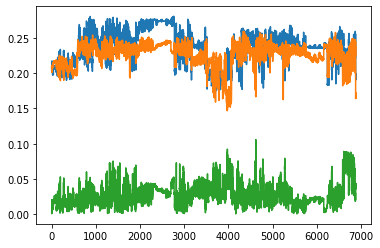

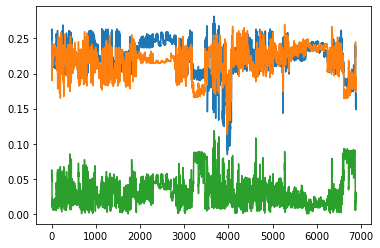

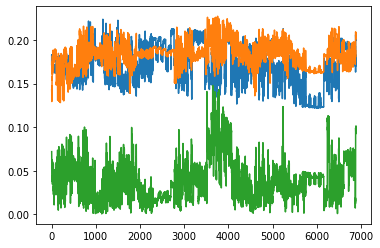

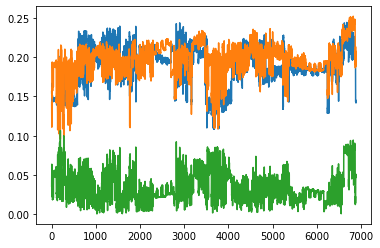

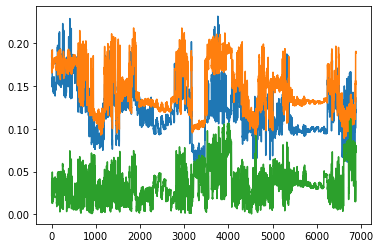

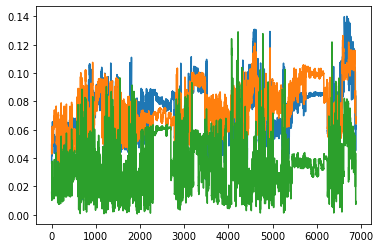

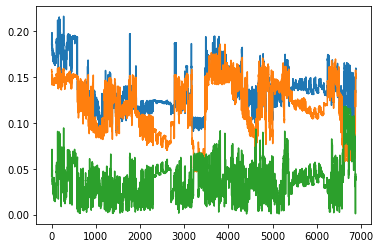

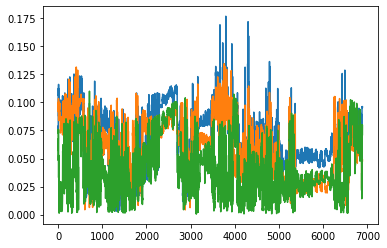

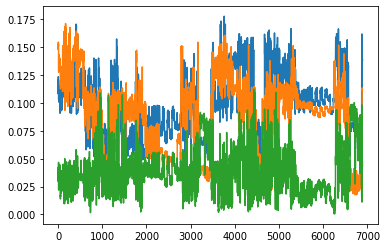

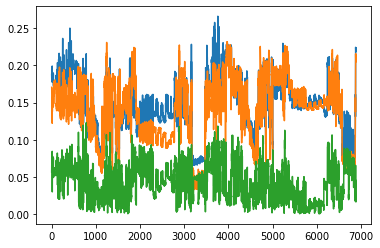

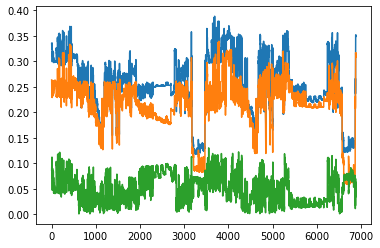

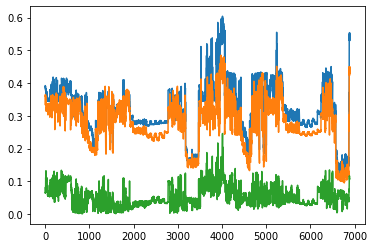

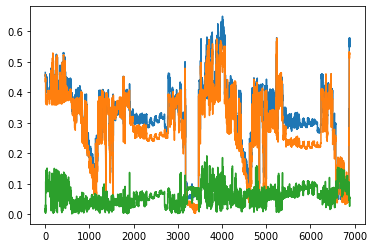

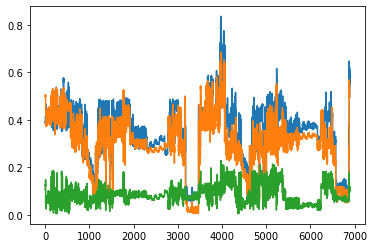

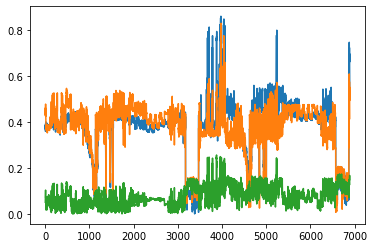

In [77]:
for i in range(16):
    plt.plot(unproj_flow2d_forward[i].norm(dim=-1).cpu())
    plt.plot(unproj_flow2d_backward[i].norm(dim=-1).cpu())
    plt.plot( ( unproj_flow2d_forward[i] + unproj_flow2d_backward[i] ).norm(dim=-1).cpu() )
    plt.show()

In [63]:
vis_mask[0]

tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')

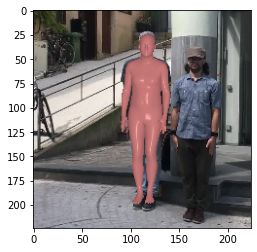

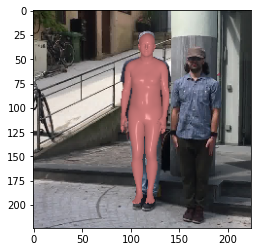

In [60]:
plt.imshow(rendered_imgs[0])
plt.show()
plt.imshow(rendered_imgs[1])

In [ ]:
# rendered_imgs = render_mesh_onto_image_batch(
#     UNNORMALIZE(img), 
#     verts3d_bbox, 
#     faces=smpl_model_faces.repeat(img.size(0),1,1), 
#     device=device)

In [ ]:
# from src.datasets.h36m import Human36M